In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

hardware_name = "L4"

gelu_gpu_run = pd.read_csv(
    f"../results/gelu_{hardware_name}_gpu.csv", header=None, names=["M", "latency", "throughput", "power", "energy", "frequency", ""]
)
gelu_gpu_run["throughput"] = (
    gelu_gpu_run["throughput"].str.extract(r"(\d+\.?\d*)").astype(float)
)
gelu_gpu_run.set_index(["M"], inplace=True)

gelu_gpu_sim = pd.read_csv(
    f"../results/gelu_{hardware_name}_sim.csv", header=None, names=["M", "latency", "throughput", "power", "total", "memory_to_l2_transfer", "l2_to_l1_transfer", "l1_to_l0_transfer", "compute"]
)
gelu_gpu_sim["throughput"] = (
    gelu_gpu_sim["throughput"].str.extract(r"(\d+\.?\d*)").astype(float)
)
gelu_gpu_sim.set_index(["M"], inplace=True)

color_NV = sns.color_palette("Greens_d", 4)[1:]

[[np.int64(4513792), np.int64(4513792), np.int64(4513792), np.int64(9027584), np.int64(13541376), np.int64(22568960), np.int64(40624128), np.int64(81248256), np.int64(162496512), np.int64(320479232), np.int64(640958464), np.int64(1277403136), np.int64(2550292480), np.int64(5100584960), np.int64(10201169920), np.int64(20402339840), np.int64(40804679680), np.int64(81604845568), np.int64(163209691136), np.int64(326419382272)], [np.float64(1205657.6), np.float64(1205657.6), np.float64(1205657.6), np.float64(2411315.2), np.float64(3616972.8), np.float64(6028288.0), np.float64(10850918.4), np.float64(21701836.8), np.float64(43403673.6), np.float64(85601689.60000001), np.float64(171203379.20000002), np.float64(341201100.8), np.float64(681196544.0), np.float64(1362393088.0), np.float64(2724786176.0), np.float64(5449572352.0), np.float64(10899144704.0), np.float64(21797083750.4), np.float64(43594167500.8), np.float64(87188335001.6)], [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64

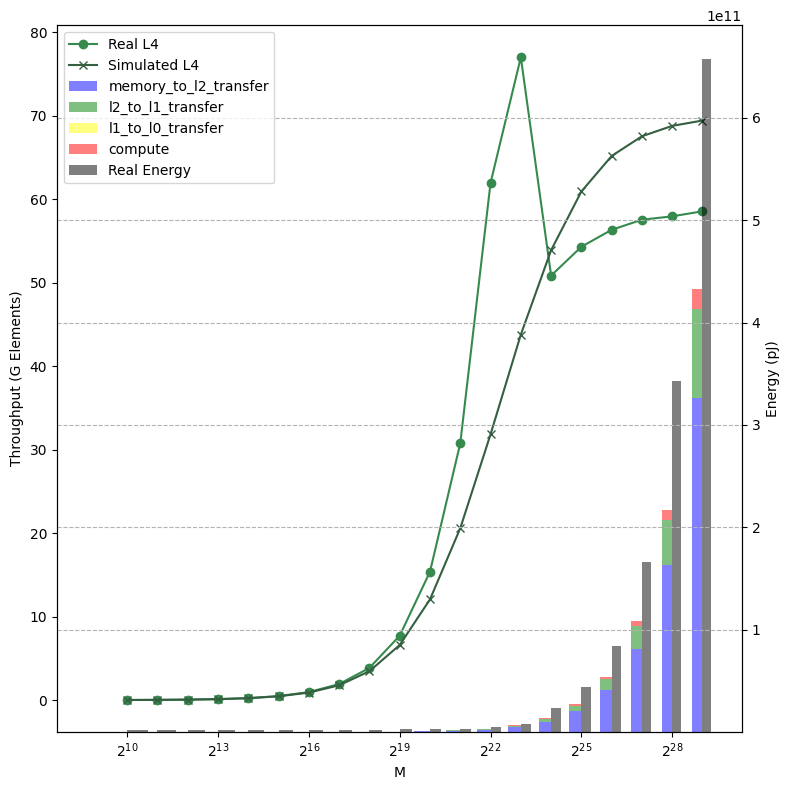

In [6]:
M_list = []
throughput_GPU_run_list = []
energy_GPU_run_list = []
throughput_GPU_sim_list = []
energy_GPU_sim_list = [[] for _ in range(4)]
for M in range(10, 30):
    M = 2**M
    M_list.append(M)
    throughput_GPU_run_list.append(gelu_gpu_run.loc[(M), "throughput"])
    energy_GPU_run_list.append(gelu_gpu_run.loc[(M), "energy"])
    throughput_GPU_sim_list.append(gelu_gpu_sim.loc[(M), "throughput"])
    energy_GPU_sim_list[0].append(gelu_gpu_sim.loc[(M), "memory_to_l2_transfer"])
    energy_GPU_sim_list[1].append(gelu_gpu_sim.loc[(M), "l2_to_l1_transfer"])
    energy_GPU_sim_list[2].append(gelu_gpu_sim.loc[(M), "l1_to_l0_transfer"])
    energy_GPU_sim_list[3].append(gelu_gpu_sim.loc[(M), "compute"])

print(energy_GPU_sim_list)

fig, ax1 = plt.subplots(figsize=(8, 8))

ax1.set_xscale("log", base=2)
ax1.set_xlabel("M")
ax1.plot(M_list, throughput_GPU_run_list, marker="o", label=f"Real {hardware_name}", color=color_NV[1])
ax1.plot(M_list, throughput_GPU_sim_list, marker="x", label=f"Simulated {hardware_name}", color=color_NV[2])
ax1.set_ylabel('Throughput (G Elements)')

ax2 = ax1.twinx()
M_list = np.array(M_list)
bar_widths = ((M_list - 2**4) * 6) / np.log2(M_list - 2**4)
ax2.bar(M_list - (bar_widths / 2), energy_GPU_sim_list[0], width=bar_widths, label='memory_to_l2_transfer', color='blue', alpha=0.5)
bottom = energy_GPU_sim_list[0]
ax2.bar(M_list - (bar_widths / 2), energy_GPU_sim_list[1], width=bar_widths, bottom=bottom, label='l2_to_l1_transfer', color='green', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[1])]
ax2.bar(M_list - (bar_widths / 2), energy_GPU_sim_list[2], width=bar_widths, bottom=bottom, label='l1_to_l0_transfer', color='yellow', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[2])]
ax2.bar(M_list - (bar_widths / 2), energy_GPU_sim_list[3], width=bar_widths, bottom=bottom, label='compute', color='red', alpha=0.5)
ax2.set_ylabel('Energy (pJ)')

ax2.bar(M_list + (bar_widths / 2), energy_GPU_run_list, width = bar_widths, label='Real Energy', color='black', alpha=0.5)

ax2.plot([], [], marker="o", label=f"Real {hardware_name}", color=color_NV[1])
ax2.plot([], [], marker="x", label=f"Simulated {hardware_name}", color=color_NV[2])

ax2.legend(loc='upper left')

plt.grid(True, which="both", ls="--", c="0.7")  # Adding a grid for better readability
plt.tight_layout()
plt.show()